In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [2]:
train = pd.read_csv('train.csv')

In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth.
    Args:
        lat1, lon1: Latitude and longitude of the first location (cardholder).
        lat2, lon2: Latitude and longitude of the second location (merchant).
    Returns:
        Distance in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [4]:
df = train.copy()
df.sort_values(by='unix_time', inplace=True)
df_by_cc = df.groupby('cc_num')

df['distance'] = haversine_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

df['prev_category_same'] = df_by_cc['category'].shift(-1) == df['category']
df['next_category_same'] = df_by_cc['category'].shift(1) == df['category']
df['both_category_different'] = df['prev_category_same'] | df['next_category_same']

# Averege time of the transaction per cc and category
# Likely hood of being in a cluster
df['avg_time'] = df.groupby(['cc_num', 'category'])['unix_time'].transform('mean')
df['cat_time_diff'] = df['unix_time'] - df['avg_time'] 

# Average time of the transaction per cc
df['avg_time_cc'] = df.groupby('cc_num')['unix_time'].diff().mean()
df['time_between_last_transaction'] = df['unix_time'] - df['unix_time'].shift(1)
df['time_between_last_transaction'].fillna(0, inplace=True)
df['diff_time'] = df['avg_time_cc'] - df['time_between_last_transaction']

df['log_amt'] = np.log1p(df['amt'])

category_mapping = {
    'entertainment': 67.569545,
    'food_dining': 69.241116,
    'gas_transport': 75.510465,
    'grocery_net': 95.306287,
    'grocery_pos': 89.268277,
    'health_fitness': 67.679297,
    'home': 65.769907,
    'kids_pets': 67.438250,
    'misc_net': 89.518433,
    'misc_pos': 85.083796,
    'personal_care': 67.630745,
    'shopping_net': 70.505666,
    'shopping_pos': 71.222801,
    'travel': 63.282025
}
df['trans_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])

# Map the values using .map() and create a new column
df['mapped_cat'] = df['category'].map(category_mapping)

df['amt-cat'] = df['amt'] - df['mapped_cat']

df['ma_10'] = df.groupby('cc_num')['amt'].transform(lambda x: x.rolling(window=10).mean()).fillna(df['amt'])
df['ma_3'] = df.groupby('cc_num')['amt'].transform(lambda x: x.rolling(window=3).mean()).fillna(df['amt'])

df['max_time_ma_3'] = df.groupby('cc_num')['ma_3'].transform('max')

df['prev_amt_diff'] = df_by_cc['amt'].diff().fillna(0)
df['next_amt_diff'] = df_by_cc['amt'].diff(-1).fillna(0)

high_amt_thresh = df['amt'].quantile(0.9)
df['high_amt_flag'] = (df['amt'] > high_amt_thresh).astype(int)
df['large_txn_ratio'] = df.groupby('cc_num')['high_amt_flag'].transform('mean')

df['Hour'] = pd.to_timedelta(df['trans_time']).dt.total_seconds() / 3600
df['night_flag'] = ((df['Hour'] >= 22) | (df['Hour'] < 4)).astype(int)

card_mean_amt = df.groupby('cc_num')['amt'].transform('mean')

# Flag transactions > 2x the mean amount for that card
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S')

df['weekday'] = df['trans_datetime'].dt.weekday

max_unix_times = df.loc[df.groupby('cc_num')['ma_3'].idxmax(), ['cc_num', 'unix_time']]

# Map the max unix time back to the original dataframe
df['max_unix_time'] = df['cc_num'].map(max_unix_times.set_index('cc_num')['unix_time'])

df['v5'] = abs(df['unix_time'] - df['max_unix_time'])
df['v6'] = df['amt'] / (df['v5'] + 1)

In [5]:
target_column = 'is_fraud'

X = df.drop(columns=[target_column, 'id', 'zip','trans_datetime', 'avg_time_cc', 'long', 'lat', 'merch_lat', 'merch_long', 'first', 'last', 'street', 'city', 'dob', 'merchant', 'trans_num','gender','time_between_last_transaction','cc_num','diff_time','avg_time','trans_date','ma_10','amt','next_category_same','distance','trans_time','max_unix_time','large_txn_ratio','large_txn_ratio'])
y = df[target_column]

non_numeric_cols = X.select_dtypes(include=['object']).columns

# Apply Label Encoding for each non-numeric column
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

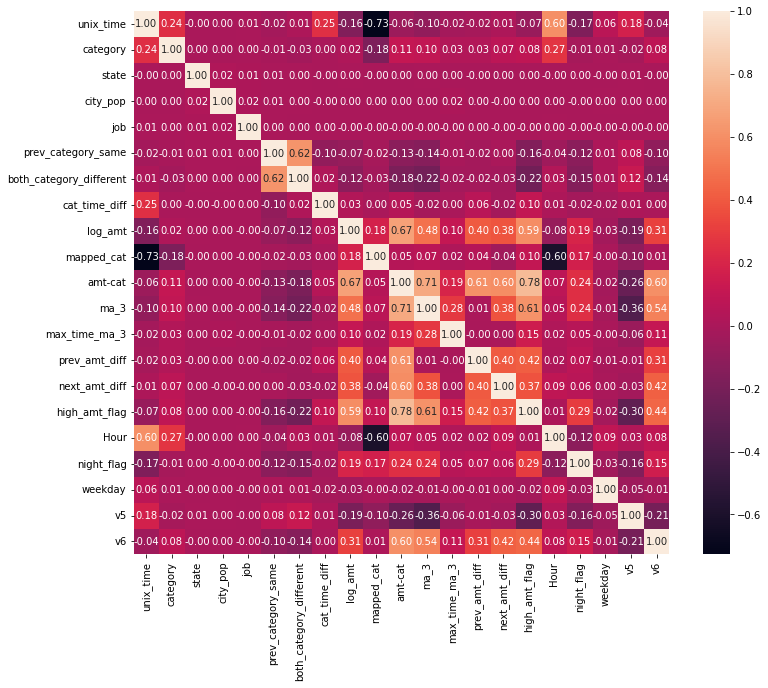

In [6]:
fig = plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, fmt=".2f")
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handles class imbalance
    random_state=42
)
rf_model.fit(X_train, y_train)

# 5. Evaluate the Model
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: Feature Importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

KeyboardInterrupt: 

In [8]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
from sklearn.metrics import classification_report
print("Classification Report with XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(accuracy_score(y_test, y_pred_xgb))

Classification Report with XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65702
           1       0.99      0.98      0.98      8439

    accuracy                           1.00     74141
   macro avg       0.99      0.99      0.99     74141
weighted avg       1.00      1.00      1.00     74141

0.995818777734317


In [568]:
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Find the threshold where precision and recall are balanced
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)  # Index of best F1-score
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold:", optimal_threshold)

# Apply adjusted threshold
y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

# Evaluate
print("Classification Report with Balanced Threshold:")
print(classification_report(y_test, y_pred_adjusted))
print("Accuracy with Balanced Threshold:", accuracy_score(y_test, y_pred_adjusted))

Optimal Threshold: 0.43
Classification Report with Balanced Threshold:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     65702
           1       0.96      0.96      0.96      8439

    accuracy                           0.99     74141
   macro avg       0.98      0.98      0.98     74141
weighted avg       0.99      0.99      0.99     74141

Accuracy with Balanced Threshold: 0.9910171160356618


In [13]:
final_train = pd.read_csv('train.csv')
final_test = pd.read_csv('test.csv')
final_df = pd.concat([final_train, final_test], axis=0)

In [14]:
final_df.sort_values(by='unix_time', inplace=True)
final_df_by_cc = final_df.groupby('cc_num')

final_df['distance'] = haversine_distance(final_df['lat'], final_df['long'], final_df['merch_lat'], final_df['merch_long'])

final_df['prev_category_same'] = final_df_by_cc['category'].shift(-1) == final_df['category']
final_df['next_category_same'] = final_df_by_cc['category'].shift(1) == final_df['category']
final_df['both_category_different'] = final_df['prev_category_same'] | final_df['next_category_same']

# Averege time of the transaction per cc and category
# Likely hood of being in a cluster
final_df['avg_time'] = final_df.groupby(['cc_num', 'category'])['unix_time'].transform('mean')
final_df['cat_time_diff'] = final_df['unix_time'] - final_df['avg_time'] 

# Average time of the transaction per cc
final_df['avg_time_cc'] = final_df.groupby('cc_num')['unix_time'].diff().mean()
final_df['time_between_last_transaction'] = final_df['unix_time'] - final_df['unix_time'].shift(1)
final_df['time_between_last_transaction'].fillna(0, inplace=True)
final_df['diff_time'] = final_df['avg_time_cc'] - final_df['time_between_last_transaction']

final_df['log_amt'] = np.log1p(final_df['amt'])

category_mapping = {
    'entertainment': 67.569545,
    'food_dining': 69.241116,
    'gas_transport': 75.510465,
    'grocery_net': 95.306287,
    'grocery_pos': 89.268277,
    'health_fitness': 67.679297,
    'home': 65.769907,
    'kids_pets': 67.438250,
    'misc_net': 89.518433,
    'misc_pos': 85.083796,
    'personal_care': 67.630745,
    'shopping_net': 70.505666,
    'shopping_pos': 71.222801,
    'travel': 63.282025
}
final_df['trans_datetime'] = pd.to_datetime(final_df['trans_date'] + ' ' + final_df['trans_time'])

# Map the values using .map() and create a new column
final_df['mapped_cat'] = final_df['category'].map(category_mapping)

final_df['amt-cat'] = final_df['amt'] - final_df['mapped_cat']

final_df['ma_10'] = final_df.groupby('cc_num')['amt'].transform(lambda x: x.rolling(window=10).mean()).fillna(final_df['amt'])
final_df['ma_3'] = final_df.groupby('cc_num')['amt'].transform(lambda x: x.rolling(window=3).mean()).fillna(final_df['amt'])

final_df['max_time_ma_3'] = final_df.groupby('cc_num')['ma_3'].transform('max')

final_df['prev_amt_diff'] = final_df_by_cc['amt'].diff().reset_index(level=0, drop=True).fillna(0)
final_df['next_amt_diff'] = final_df_by_cc['amt'].diff(-1).reset_index(level=0, drop=True).fillna(0)


high_amt_thresh = final_df['amt'].quantile(0.9)
final_df['high_amt_flag'] = (final_df['amt'] > high_amt_thresh).astype(int)
final_df['large_txn_ratio'] = final_df.groupby('cc_num')['high_amt_flag'].transform('mean')

final_df['Hour'] = pd.to_timedelta(final_df['trans_time']).dt.total_seconds() / 3600
final_df['night_flag'] = ((final_df['Hour'] >= 22) | (final_df['Hour'] < 4)).astype(int)

card_mean_amt = final_df.groupby('cc_num')['amt'].transform('mean')

# Flag transactions > 2x the mean amount for that card
final_df['trans_date'] = pd.to_datetime(final_df['trans_date'])
final_df['trans_time'] = pd.to_datetime(final_df['trans_time'], format='%H:%M:%S')

final_df['weekday'] = final_df['trans_datetime'].dt.weekday

max_unix_times = final_df.loc[final_df.groupby('cc_num')['ma_3'].idxmax(), ['cc_num', 'unix_time']]

# Drop duplicate cc_num to ensure uniqueness
max_unix_times = max_unix_times.drop_duplicates(subset='cc_num').set_index('cc_num')

# Map the max unix time back to the original dataframe
final_df['max_unix_time'] = final_df['cc_num'].map(max_unix_times['unix_time'])

final_df['v5'] = abs(final_df['unix_time'] - final_df['max_unix_time'])
final_df['v6'] = final_df['amt'] / (final_df['v5'] + 1)

In [15]:
max_unix_times = final_df.loc[final_df.groupby('cc_num')['ma_3'].idxmax(), ['cc_num', 'unix_time']]

# Drop duplicate cc_num to ensure uniqueness
max_unix_times = max_unix_times.drop_duplicates(subset='cc_num').set_index('cc_num')

# Map the max unix time back to the original dataframe
final_df['max_unix_time'] = final_df['cc_num'].map(max_unix_times['unix_time'])


In [16]:
final = final_df[final_df['id'].isin(final_test['id'])]

X_final = final.drop(columns=[target_column, 'id', 'zip','trans_datetime', 'avg_time_cc', 'long', 'lat', 'merch_lat', 'merch_long', 'first', 'last', 'street', 'city', 'dob', 'merchant', 'trans_num','gender','time_between_last_transaction','cc_num','diff_time','avg_time','trans_date','ma_10','amt','next_category_same','distance','trans_time','max_unix_time','large_txn_ratio','large_txn_ratio'])

non_numeric_cols = X_final.select_dtypes(include=['object']).columns

# Apply Label Encoding for each non-numeric column
le = LabelEncoder()
for col in non_numeric_cols:
    X_final[col] = le.fit_transform(X_final[col].astype(str))

# y_final_prob = rf_model.predict_proba(X_final)[:, 1]
# y_final = (y_final_prob >= optimal_threshold).astype(int)

y_final = xgb_model.predict(X_final)

In [22]:
output_df = pd.DataFrame({
    'id': final['id'],
    'is_fraud': y_final
})

# Writing to a CSV file
output_df.to_csv('submission.csv', index=False)

In [23]:
out = output_df['is_fraud'].value_counts()
out

0    82083
1    10593
Name: is_fraud, dtype: int64

In [24]:
out[1]/out[0]

0.12905230072000293